Define the Environment Class

In [2]:
import numpy as np
import random

# A simplified environment with 3 zones and 24 hours
ZONES = ['A', 'B', 'C']
NUM_HOURS = 24
IDLE_STATUS = 0
PASSENGER_STATUS = 1

In [3]:
class CabEnv:
    def __init__(self):
        # State = (cab_zone, hour, status)
        self.state_space = []
        for zone in ZONES:
            for hour in range(NUM_HOURS):
                for status in [IDLE_STATUS, PASSENGER_STATUS]:
                    self.state_space.append((zone, hour, status))

        # A simple reward/fare matrix (fare for a trip from A to B, etc.)
        self.fare_matrix = {
            ('A', 'B'): 20,
            ('B', 'A'): 20,
            ('A', 'C'): 30,
            ('C', 'A'): 30,
            ('B', 'C'): 15,
            ('C', 'B'): 15
        }

        # Action space: Drive to A, B, or C
        self.action_space = ['Drive to A', 'Drive to B', 'Drive to C']

    def get_state_index(self, state):
        return self.state_space.index(state)

    def get_reward(self, start_zone, end_zone, status):
        # A simple reward function
        if status == PASSENGER_STATUS:
            return self.fare_matrix.get((start_zone, end_zone), -5) # -5 for illegal trip
        else:
            return -1 # Penalty for idle travel or waiting

    def get_next_state(self, current_state, action):
        cab_zone, hour, status = current_state

        if "Drive to" in action:
            new_zone = action.split(' ')[-1]
            next_hour = (hour + 1) % NUM_HOURS # Time advances by 1 hour
            # Assume a passenger might appear in the new zone
            if random.random() < 0.5: # 50% chance of a passenger
                new_status = PASSENGER_STATUS
            else:
                new_status = IDLE_STATUS
            return (new_zone, next_hour, new_status)
        else:
            return current_state

Implement the Q-Learning Agent

In [4]:
class CabAgent:
    def __init__(self, env, alpha=0.1, gamma=0.95, epsilon=1.0):
        self.env = env
        self.q_table = np.zeros((len(env.state_space), len(env.action_space)))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def choose_action(self, current_state_index):
        if random.random() < self.epsilon:
            # Explore: choose a random action
            action_index = random.choice(range(len(self.env.action_space)))
        else:
            # Exploit: choose the best action
            action_index = np.argmax(self.q_table[current_state_index, :])
        return action_index

    def update_q_table(self, current_state_index, action_index, reward, next_state_index):
        # Bellman equation to update the Q-value
        old_value = self.q_table[current_state_index, action_index]
        future_reward = np.max(self.q_table[next_state_index, :])

        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * future_reward)
        self.q_table[current_state_index, action_index] = new_value

    def decay_epsilon(self):
        self.epsilon = max(0.01, self.epsilon * 0.999)

Train the agent

In [5]:
env = CabEnv()
agent = CabAgent(env)

num_episodes = 10000

for episode in range(num_episodes):
    current_state = random.choice(env.state_space)

    # An episode ends when the cab driver has completed a full cycle (e.g., 24 hours)
    for step in range(24): # A simplified 24-hour day
        current_state_index = env.get_state_index(current_state)
        action_index = agent.choose_action(current_state_index)

        action = env.action_space[action_index]
        next_state = env.get_next_state(current_state, action)

        reward = env.get_reward(current_state[0], next_state[0], next_state[2])
        next_state_index = env.get_state_index(next_state)

        agent.update_q_table(current_state_index, action_index, reward, next_state_index)

        current_state = next_state

    agent.decay_epsilon()

    if episode % 1000 == 0:
        print(f"Episode {episode}: Epsilon = {agent.epsilon:.2f}")

print("Training complete!")

Episode 0: Epsilon = 1.00
Episode 1000: Epsilon = 0.37
Episode 2000: Epsilon = 0.14
Episode 3000: Epsilon = 0.05
Episode 4000: Epsilon = 0.02
Episode 5000: Epsilon = 0.01
Episode 6000: Epsilon = 0.01
Episode 7000: Epsilon = 0.01
Episode 8000: Epsilon = 0.01
Episode 9000: Epsilon = 0.01
Training complete!


Testing

In [6]:
# Set the agent to purely exploit its knowledge
agent.epsilon = 0.0

In [7]:
def test_agent(agent, env, num_test_episodes=10):
    total_rewards = []

    # Set the agent to exploitation mode
    agent.epsilon = 0.0

    for episode in range(num_test_episodes):
        current_state = random.choice(env.state_space)
        episode_reward = 0

        print(f"\n--- Starting Test Episode {episode + 1} ---")

        # Simulate a full 24-hour day
        for step in range(24):
            current_state_index = env.get_state_index(current_state)

            # The agent chooses the best action based on the Q-table
            action_index = agent.choose_action(current_state_index)
            action = env.action_space[action_index]

            # Transition to the next state
            next_state = env.get_next_state(current_state, action)

            # Get the reward for this step
            reward = env.get_reward(current_state[0], next_state[0], next_state[2])

            # Accumulate the episode reward
            episode_reward += reward

            # Print the agent's actions and rewards
            print(f"  Step {step}: State = {current_state}, Action = '{action}', Reward = {reward}")

            current_state = next_state

        print(f"--- Episode {episode + 1} finished with total reward: {episode_reward} ---")
        total_rewards.append(episode_reward)

    avg_reward = sum(total_rewards) / len(total_rewards)
    print(f"\nAverage reward over {num_test_episodes} test episodes: {avg_reward:.2f}")

# Call the test function after your training loop
test_agent(agent, env)


--- Starting Test Episode 1 ---
  Step 0: State = ('A', 1, 1), Action = 'Drive to C', Reward = 30
  Step 1: State = ('C', 2, 1), Action = 'Drive to A', Reward = 30
  Step 2: State = ('A', 3, 1), Action = 'Drive to C', Reward = 30
  Step 3: State = ('C', 4, 1), Action = 'Drive to A', Reward = -1
  Step 4: State = ('A', 5, 0), Action = 'Drive to C', Reward = -1
  Step 5: State = ('C', 6, 0), Action = 'Drive to A', Reward = -1
  Step 6: State = ('A', 7, 0), Action = 'Drive to C', Reward = 30
  Step 7: State = ('C', 8, 1), Action = 'Drive to A', Reward = 30
  Step 8: State = ('A', 9, 1), Action = 'Drive to B', Reward = -1
  Step 9: State = ('B', 10, 0), Action = 'Drive to C', Reward = -1
  Step 10: State = ('C', 11, 0), Action = 'Drive to A', Reward = -1
  Step 11: State = ('A', 12, 0), Action = 'Drive to C', Reward = -1
  Step 12: State = ('C', 13, 0), Action = 'Drive to A', Reward = -1
  Step 13: State = ('A', 14, 0), Action = 'Drive to C', Reward = 30
  Step 14: State = ('C', 15, 1), A

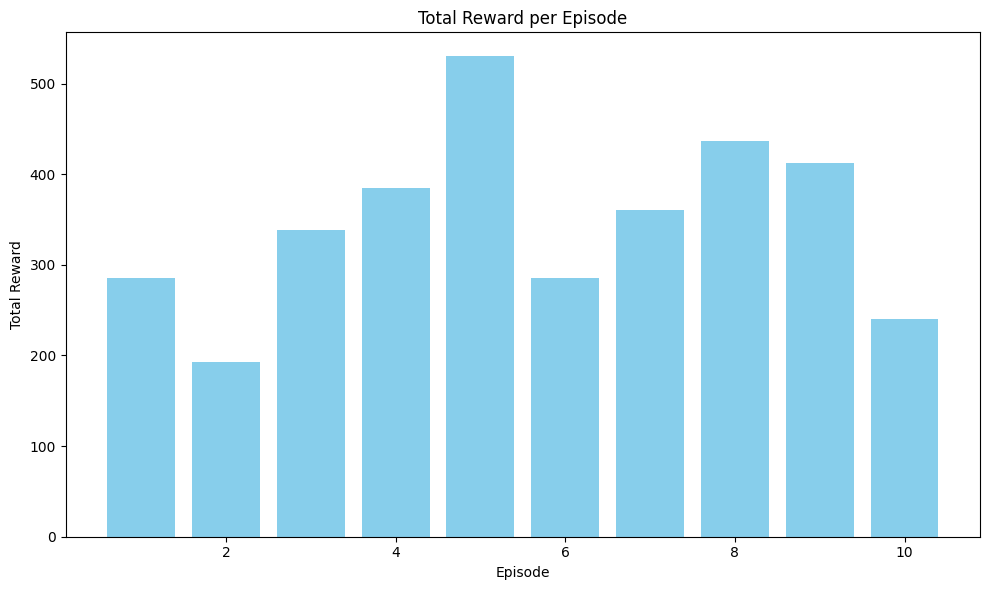

In [8]:
# Analysis
import matplotlib.pyplot as plt

# Total rewards from the user's output
total_rewards = [286, 193, 338, 385, 530, 286, 360, 437, 412, 240]
episodes = np.arange(1, len(total_rewards) + 1)

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(episodes, total_rewards, color='skyblue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.tight_layout()
plt.show()